# Load Libraries

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score

pd.set_option('display.max_columns', None)

# Load Data and Preprocessing

In [4]:
data = pd.read_csv('ALL_SEASONS.csv')

In [5]:
X = data.copy()

sc  = StandardScaler()
le = LabelEncoder()
X['driver'] = le.fit_transform(X['driver'])

X_train = X[(X['season'] < 2023) ].drop('grid',axis = 1)
y_train = X[X['season'] < 2023]['grid']

In [6]:
X_2023 = X[(X['season'] == 2023) & (X['round'] < 4)].drop('grid',axis = 1)
y_2023 = X[(X['season'] == 2023) & (X['round'] < 4)]['grid']

X_train = pd.concat([X_train,X_2023])
y_train = pd.concat([y_train,y_2023])

In [7]:
X_test = X[(X['season'] == 2023) & (X['round'] == 4)].drop('grid',axis = 1)
y_test = X[(X['season'] == 2023) & (X['round'] == 4)]['grid']

# Random Forest

Create gird for hyperparameter tuning

In [8]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

Run hyperparameter tuning. Only need to run once, hence why it will be commented out.

In [9]:
# rf_rand = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=10,cv=10,verbose=2,n_jobs=-1 )
# rf_random.fit(X,y)
# rf_random.best_params_

Create a RandomForest Classifier with the best params according to the hyperparameter tuning.

Also create a stratified K Fold for Cross Validation.

In [10]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=8,min_samples_leaf=4,max_features='sqrt',max_depth=70,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
# for train_index,test_index in kf.split(X,y):
#     X_train,X_test = X.iloc[train_index],X.iloc[test_index]
#     y_train,y_test = y.iloc[train_index],y.iloc[test_index]

## Fit the model and make predictions

In [11]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

In [12]:
rf_ = RandomForestClassifier(n_estimators=1600,min_samples_split=8,min_samples_leaf=4,max_features='sqrt',max_depth=70,bootstrap=True)
rf_.fit(X_train.drop('podium',axis=1), y_train)

RandomForestClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=1600)

In [13]:
X_later = X_test.copy()
X_later = X_later[['season','round','driver']]

X_later['pred_pos'] = y_pred_rf
X_later['actual'] = y_test

In [14]:
X_later = X_later.sort_values(by = 'pred_pos')

The predicitons will be ordered, however it is necessary to make a small adjustment as two drivers might be given the same prediction however the order helps to clarify this.

In [15]:
X_later['pred_pos'] = [pos for pos in range(1,len(X_later)+1)]

In [16]:
X_later['driver'] = le.inverse_transform(X_later['driver'])

As we can see, predictions are pretty close.

In [17]:
X_later

,season,round,driver,pred_pos,actual
15000,2023,4,leclerc,1,1
15001,2023,4,max_verstappen,2,2
15002,2023,4,perez,3,3
15003,2023,4,sainz,4,4
15005,2023,4,alonso,5,6
15010,2023,4,russell,6,11
15008,2023,4,stroll,7,9
15004,2023,4,hamilton,8,5
15007,2023,4,tsunoda,9,8
15009,2023,4,piastri,10,10


# Support Vector Classifier

In [18]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred_svc)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

In [19]:
X_later = X_test.copy()
X_later = X_later[['season','round','driver',]]

X_later['pred_pos'] = y_pred_rf
X_later['actual'] = y_test

X_later = X_later.sort_values(by = 'pred_pos')

In [20]:
X_later['driver'] = le.inverse_transform(X_later['driver'])

In [21]:
X_later['pred_pos'] = [pos for pos in range(1, len(X_later)+1)]

In [22]:
X_later

,season,round,driver,pred_pos,actual
15000,2023,4,leclerc,1,1
15001,2023,4,max_verstappen,2,2
15002,2023,4,perez,3,3
15003,2023,4,sainz,4,4
15005,2023,4,alonso,5,6
15010,2023,4,russell,6,11
15008,2023,4,stroll,7,9
15004,2023,4,hamilton,8,5
15007,2023,4,tsunoda,9,8
15009,2023,4,piastri,10,10


# Linear Discriminant Analysis

In [23]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
cnf_mat_lda = confusion_matrix(y_test,y_pred_lda)
cnf_mat_lda = cnf_mat_lda/cnf_mat_lda.sum()

In [24]:
X_later = X_test.copy()
X_later = X_later[['season','round','driver']]
X_later['pred_pos'] = y_pred_lda
X_later['actual'] = y_test
X_later = X_later.sort_values(by = 'pred_pos')


In [25]:
X_later['driver'] = le.inverse_transform(X_later['driver'])

In [26]:
X_later['pred_pos'] = [pos for pos in range(1, len(X_later)+1)]

In [27]:
X_later

,season,round,driver,pred_pos,actual
15000,2023,4,leclerc,1,1
15001,2023,4,max_verstappen,2,2
15002,2023,4,perez,3,3
15003,2023,4,sainz,4,4
15005,2023,4,alonso,5,6
15004,2023,4,hamilton,6,5
15010,2023,4,russell,7,11
15008,2023,4,stroll,8,9
15009,2023,4,piastri,9,10
15006,2023,4,norris,10,7


# Metrics and Comparison

In [28]:
rf_pression = precision_score(y_test, y_pred_rf, average = 'micro' )
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')

/Users/estebansanchez/Dropbox/Mac/Desktop/F1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')

In [30]:
lda_pression = precision_score(y_test, y_pred_lda, average='micro')
lda_f1 = f1_score(y_test,y_pred_lda,average='macro')
lda_recall = recall_score(y_test,y_pred_lda,average='macro')

/Users/estebansanchez/Dropbox/Mac/Desktop/F1/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    # 'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall},
    # 'LDA': {'precision_score':lda_pression,'f1_score':lda_f1,'recall_score':lda_recall}
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier
f1_score,0.210526
precision_score,0.277778
recall_score,0.263158


# Save best model

In [32]:
filename = 'rf_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)

# Model Explainability

## Permutation Importance

In [33]:
import eli5
from eli5.sklearn import PermutationImportance

2024-05-03 14:48:26.990250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
# Calculate Permutation Importance
perm = PermutationImportance(rf_, random_state=1).fit(X_test.drop('podium',axis=1), y_test)

# Show weights
eli5.show_weights(perm, feature_names = X_test.drop('podium',axis=1).columns.tolist())

Weight,Feature
0.1667 ± 0.0000,qualifying_time
0.0556 ± 0.0000,driver_wins
0.0222 ± 0.0889,constructor_points
0.0111 ± 0.0831,constructor_wins
0 ± 0.0000,circuit_id_kyalami
0 ± 0.0000,circuit_id_magny_cours
0 ± 0.0000,circuit_id_marina_bay
0 ± 0.0000,circuit_id_monaco
0 ± 0.0000,circuit_id_monza
0 ± 0.0000,circuit_id_jacarepagua


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


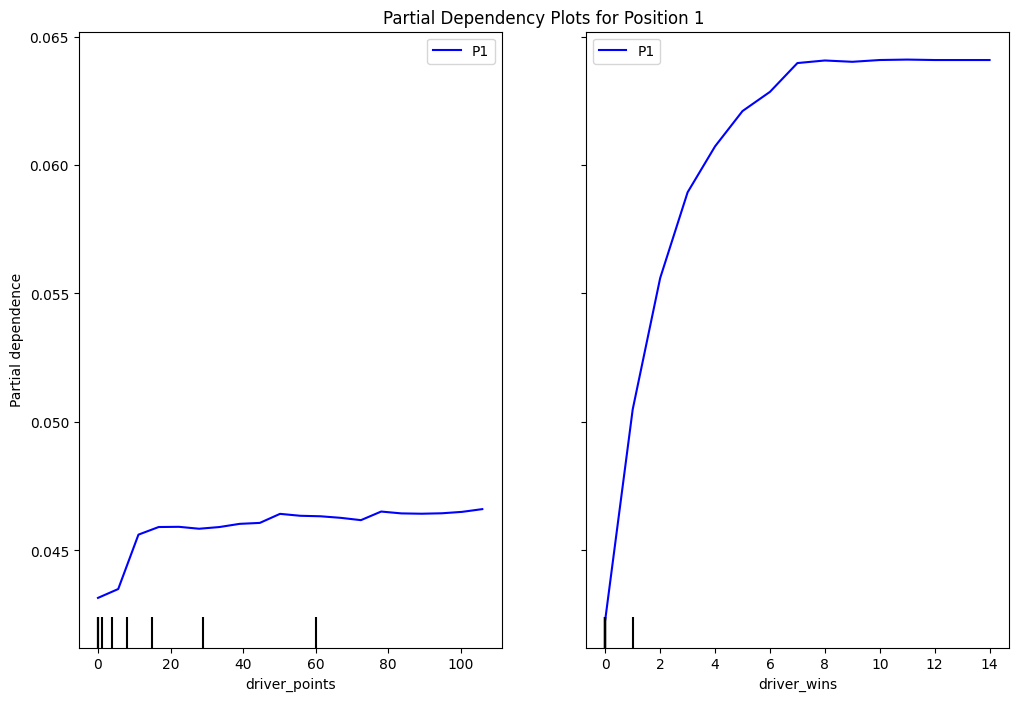

In [62]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Specify the features for which we want the PDPs
features = [] # These are feature indices. Adjust as needed.

# Create the PDP for the first class
# Note: You can also loop through classes if needed
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    rf_,
    X_train.drop('podium',axis=1),
    features,
    kind="average",
    ax=ax,
    target=1,  # Adjust the target class index as per your model
    grid_resolution=20,  # Number of bins per axis in the grid
    line_kw={"color": "blue", "label": "P1"}  # Styling for lines
)

ax.set_title('Partial Dependency Plots for Position 1')
ax.legend()
plt.show()


In [155]:
import shap

explainer = shap.TreeExplainer(rf_)
single_instance = X_test.drop('podium',axis=1).iloc[0:1,:]  # Single instance
shap_values_single = explainer.shap_values(single_instance).transpose()

shap.initjs() 
shap.force_plot(explainer.expected_value[0], shap_values_single[0].transpose(), single_instance)

force_plot = shap.force_plot(explainer.expected_value[0], shap_values_single[0].transpose(), single_instance)

# Save the plot to an HTML file
shap.save_html('SHAP_leclerc_r4.html', force_plot)


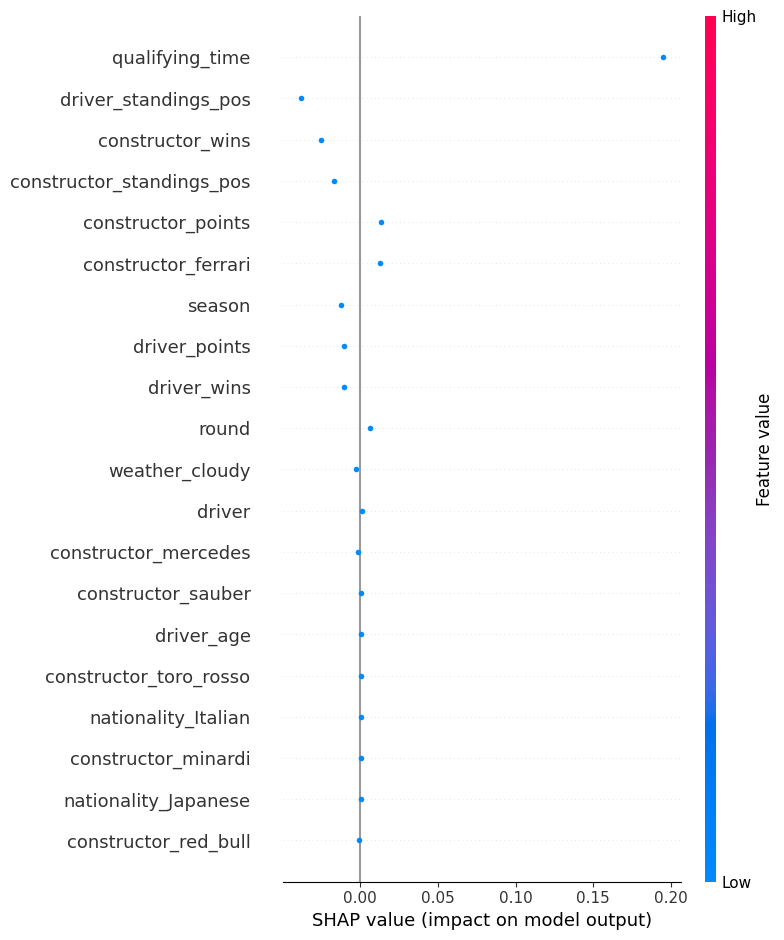

In [159]:
explainer = shap.TreeExplainer(rf_)
single_instance = X_test.drop('podium',axis=1).iloc[0:1,:]  # Single instance
shap_values_single = explainer.shap_values(single_instance).transpose()

# make plot.
shap.summary_plot(shap_values_single[0].transpose(), single_instance)